In [1]:
import os
import argparse
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from PIL import Image

In [2]:
parser = argparse.ArgumentParser(description="coco")
parser.add_argument("--data_path", default="/data/dataset/v-coco/coco/", type=str)
args = parser.parse_args([])

In [3]:
class GetCOCO():
    def __init__(self, mode='train'):
        self.mode = mode
        json_path = os.path.join(args.data_path, 'annotations', f'instances_{mode}2014.json')
        self.imgs_path = os.path.join(args.data_path, 'images', f'{mode}2014')
        
        self.coco = COCO(annotation_file=json_path)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
        category_ids = self.coco.getCatIds()
        cmap = plt.get_cmap('prism')
        self.label_colors = [tuple([int(c*254) for c in cmap(i/128)[:3]]) for i in range(max(category_ids))]
        
    def show(self, num=0):
        coco = self.coco
        
        img_id = self.ids[num]
        imgs = coco.loadImgs(img_id)[0]
        ann_ids = coco.getAnnIds(img_id)
        targets = coco.loadAnns(ann_ids)
        
        image_name = imgs['file_name']
        image_path = os.path.join(self.imgs_path, image_name)
        image = cv2.imread(image_path)
        
        for i, target in targets:
            cat_id = target['category_id']
            cat_name = coco.cats[cat_id]['name']
            x, y, w, h = target['bbox']
            x1, y1, x2, y2 = x, y, x + w, y + h
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            # print(cat_id, cat_name)
            color = self.label_colors[cat_id]
            cv2.putText(
                image, cat_name, (x1+2, y1+20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2, color=color
            )
            cv2.rectangle(
                image, (x1, y1), (x2, y2), color=color, thickness=3
            )
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis('off')
        plt.title(image_name)
        plt.show()
        
    def to_tsv(self):
        coco = self.coco
        outputs = ""
        for i, img_id in enumerate(self.ids):
            
            imgs = coco.loadImgs(img_id)[0]
            ann_ids = coco.getAnnIds(img_id)
            targets = coco.loadAnns(ann_ids)
            targets = coco.loadAnns(ann_ids)
            
            image_name = imgs['file_name']
            image_path = os.path.join(self.imgs_path, image_name)
            image = Image.open(image_path).convert("RGB")
            
            img_buffer = BytesIO()
            image.save(img_buffer, format='png')#img.format)
            byte_data = img_buffer.getvalue()
            base64_str = base64.b64encode(byte_data) # bytes
            base64_str = base64_str.decode("utf-8") # str
            output = f"{i+1}\t{base64_str}\t"
            
            for target in targets:
                cat_id = target['category_id']
                cat_name = coco.cats[cat_id]['name']
                x, y, w, h = target['bbox']
                x1, y1, x2, y2 = x, y, x + w, y + h
                output += f'{x1},{y1},{x2},{y2},{cat_id},{cat_name}&&'
                
            output = output[:-2]
            output += '\n'
            
            outputs += output
        
        out_path = f"outputs/hico-det_{self.mode}.tsv"
        print(f'writing to {out_path}...')
        with open(out_path, "w", encoding='utf-8') as f:
            f.write(outputs)
        print('done')

In [4]:
train_coco = GetCOCO('train')

loading annotations into memory...
Done (t=5.07s)
creating index...
index created!


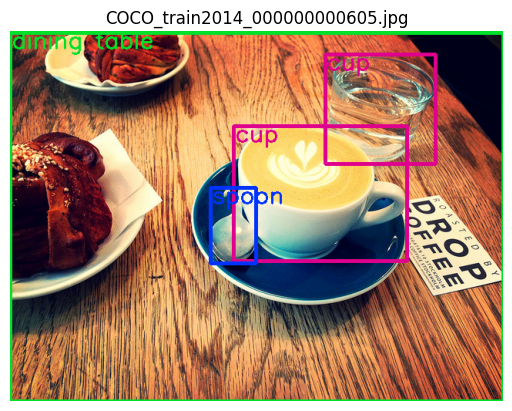

In [5]:
train_coco.show(77)

In [6]:
train_coco = GetCOCO('val')

loading annotations into memory...
Done (t=3.14s)
creating index...
index created!


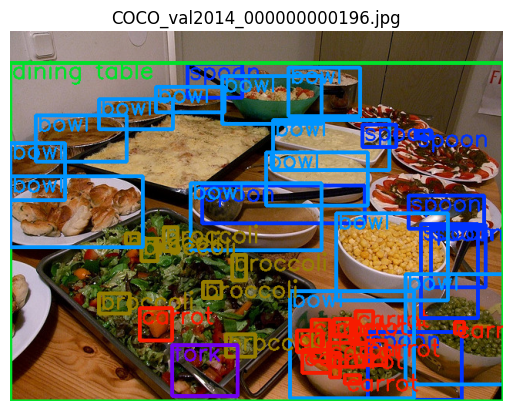

In [12]:
train_coco.show(9)